 ## 02 - EDA on book genre

The following notebook will investigate the effect of book's characteristics
have on average daily sales. Eights features included in the dataset can be
broken down into 4 main groups:
1. price
2. ratings and reviews
3. publisher
4. genre

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from book_analysis.utils.visuals import *

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# paths for easy loading and saving
data_path = 'D:\\PycharmProjects\\springboard\\data'
image_path = 'D:\\PycharmProjects\\springboard\\book_analysis\\images'

# loading data
sales = pd.read_csv(f'{data_path}\\book_sales.csv', index_col=[0])

# Info on dataset
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27027 entries, 0 to 27026
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   genre                     27027 non-null  object 
 1   sold_by                   27027 non-null  object 
 2   daily_average_units_sold  27027 non-null  int64  
 3   publisher_name            27027 non-null  object 
 4   publisher_type            27027 non-null  object 
 5   average_rating            27027 non-null  float64
 6   sale_price                27027 non-null  float64
 7   total_reviews             27027 non-null  int64  
 8   price_range               27027 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 2.1+ MB
None


A quick summary of how numerical variables interact using pairplot.

In [3]:
sales.describe()

,daily_average_units_sold,average_rating,sale_price,total_reviews
count,27027.000000,27027.000000,27027.000000,27027.000000
mean,29.614053,4.159787,6.777488,136.099345
std,157.739500,0.995815,6.368486,468.952999
min,1.000000,0.000000,0.010000,0.000000
25%,4.000000,4.080000,2.990000,12.000000
50%,9.000000,4.400000,5.120000,37.000000
75%,14.000000,4.640000,9.990000,111.000000
max,7000.000000,5.000000,141.520000,23362.000000


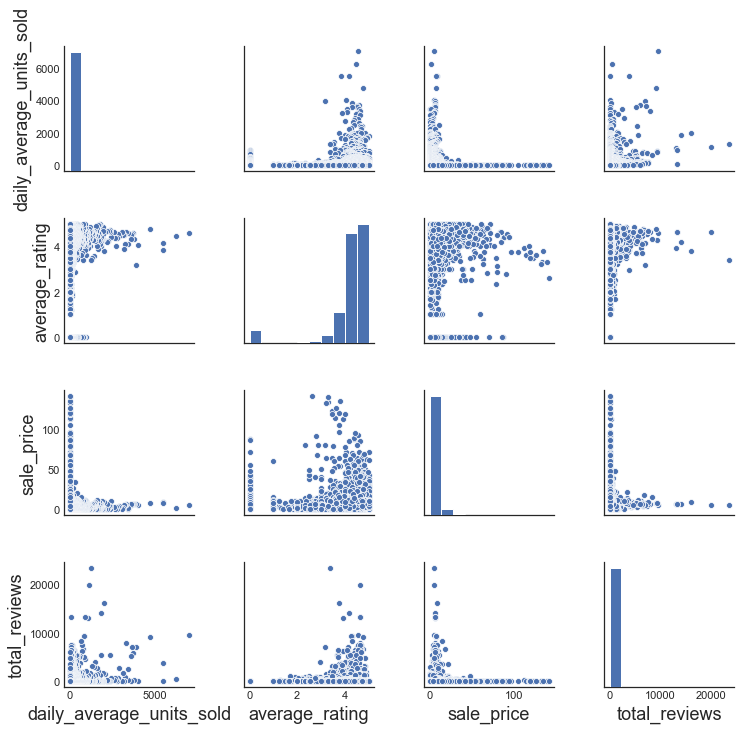

In [4]:
sns.pairplot(sales)

Note the discrepancy of book sales. A few books have a sales in the thousands and
up to 7000 sales daily while the majority of titles enjoy much less sales. In fact,
there are only 99 books (0.3%) that sell over 1000 copies daily.

In [5]:
# Table with sales bracket count
sales['sales_bracket'] = pd.cut(sales.daily_average_units_sold, bins=np.arange(0,8000,1000))
sales.groupby('sales_bracket')['daily_average_units_sold'].count().reset_index()

,sales_bracket,daily_average_units_sold
0,"(0, 1000]",26928
1,"(1000, 2000]",65
2,"(2000, 3000]",14
3,"(3000, 4000]",15
4,"(4000, 5000]",1
5,"(5000, 6000]",2
6,"(6000, 7000]",2


Going a bit further by taking only titles that sell less than 1000 copies daily,
there is again a long right tail which signifies most titles sell below 100
mark daily.

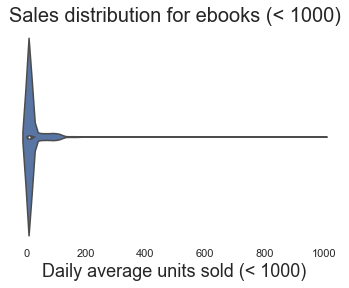

In [6]:
# distribution of books sales
sns.violinplot(sales[sales.daily_average_units_sold < 1000].daily_average_units_sold)

# plot parameters
plt.title('Sales distribution for ebooks (< 1000)')
plt.xlabel('Daily average units sold (< 1000)')
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.savefig(f'{image_path}\\ebook_sales_1000_distribution.png')

# 1. Price

First, lets see how much pricing effect the demand for books. Some insights:
1. sale_price has a large variance. Almost all books with price higher than $30
is non-fiction. One reason for this is non-fiction includes textbooks,
academic books, collections that are very expensive to produce with high markup.
2. Focusing in on the daily_sales vs. price plot. Surprisingly, there is a very
minor relationship between these two. (almost zero correlation)
3. Median price of 5.12 is very closed to average book price of 6.78. Over
75% of ebooks has the price tag under 10 dollars.

In [7]:
# book genre that has prices over 30 dollars
sales[sales.sale_price > 30]['genre'].value_counts()

nonfiction       210
genre fiction      9
Name: genre, dtype: int64

In [8]:
# Median sale price
print('Median book price:', sales.sale_price.median())
print('Mean book price:', sales.sale_price.mean())

Median book price: 5.12
Mean book price: 6.777487697487698


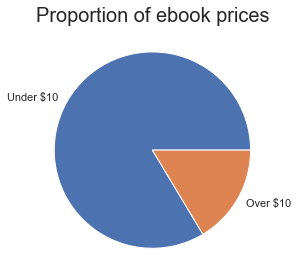

In [9]:
# Number of book price under 10 dollars
under_10 = sum([True for x in sales.sale_price if x < 10])
over_10 = len(sales) - under_10

# pie plot of proportion of book prices
df = pd.DataFrame({'n':[under_10, over_10]},
                  index=['under 10', 'over 10'])
df.plot.pie(y='n', labels=['Under $10', 'Over $10'])

# plot parameters
plt.ylabel('')
plt.title('Proportion of ebook prices')
plt.tight_layout()
plt.gca().get_legend().remove()
plt.savefig(f'{image_path}\\proportion_book_under10.png')

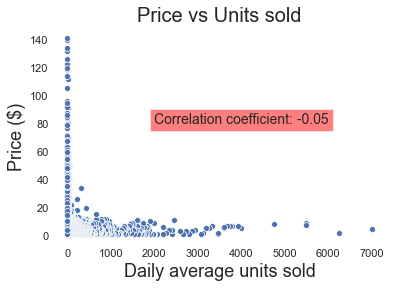

In [10]:
# sale_price vs daily_average_unit_sold for books that sale over 1000 copies
sns.scatterplot(y='sale_price',
                x='daily_average_units_sold',
                data=sales)

# correlation
corr = np.corrcoef(sales.daily_average_units_sold, sales.sale_price)
text = f'Correlation coefficient: {np.round(corr[0,1],2)}'

# plot parameters
plt.xlabel('Daily average units sold')
plt.ylabel('Price ($)')
plt.title('Price vs Units sold')
sns.despine(left='True', bottom='True')
plt.text(x=2000,
         y=80,
         s=text,
         fontsize=14,
         bbox=dict(facecolor='red', alpha=0.5))
plt.savefig(f'{image_path}\\price_unit_sold_correlation.png')

Before moving on to ratings and reviews, lets see how different publisher type
set their prices. Since the variance in price is large, y scale is transformed
with log(x+1) scale. (price below 1 gives negative values).

All books with price below 1 dollar are from by small/medium publishers.
Titles published by big five has the highest median price.

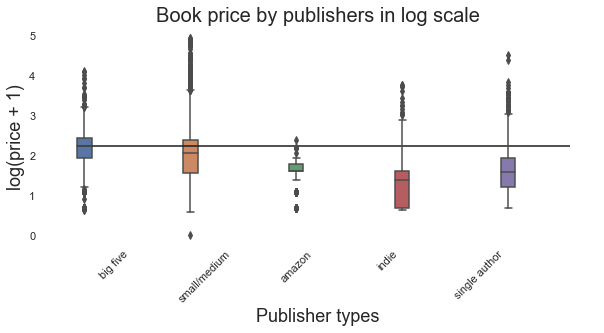

In [11]:
# price scatter with publisher
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(ax=ax,
            x='publisher_type',
            y=np.log(sales.sale_price + 1),
            hue='publisher_type',
            data=sales,)

# big give median for comparison
big_five_median = sales[sales.publisher_type=='big five'].sale_price.median()

# plot parameters
plt.title('Book price by publishers in log scale')
plt.xlabel('Publisher types')
plt.xticks(rotation=45)
plt.ylabel('log(price + 1)')
plt.hlines(y=np.log(big_five_median+1),xmin=-.4,xmax=5)
sns.despine(left=True, bottom=True)
plt.gca().get_legend().remove()

plt.savefig(f'{image_path}\\price_publisher_type.png')

# 2. Ratings and reviews

This section will utilize both book sales and book rating datasets to get a more
comprehensive look on book rating and reviews. Book rating data only include
the titles, average rating and total number of rating. It is useful for learning
more about books with good reviews.

average ratings + distribution, sales, publishers, total_reviews

total reviews _ distribution, sales

### 2.1 - Rating

The distribution of ebooks rating is heavily right skewed. Majority of titles
have ratings between 3 and 5 stars. What about the group of books with zero rating?
Those books have no reviews written and thus no rating was recorded. Unsurprisingly,
they sells badly with mean of 23 and median of 6.

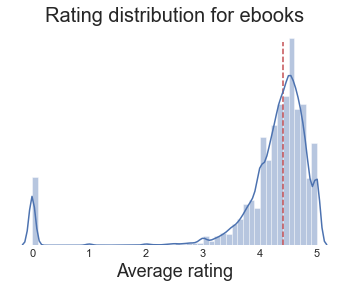

In [12]:
# distribution of books rating from sales data
sns.distplot(sales.average_rating)

# Include the median values in the plot
plt.vlines(x=sales.average_rating.median(),
           ymin=0,
           ymax=1.3,
           color='r',
           linestyles='--')

# plot parameters
plt.title('Rating distribution for ebooks')
plt.xlabel('Average rating')
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.savefig(f'{image_path}\\ebook_rating_distribution.png')

In [13]:
# books with average rating of zero
sales[sales.average_rating==0].describe()

,daily_average_units_sold,average_rating,sale_price,total_reviews
count,1182.000000,1182.0,1182.000000,1182.0
mean,22.859560,0.0,7.071836,0.0
std,67.285852,0.0,6.886107,0.0
min,1.000000,0.0,0.990000,0.0
25%,2.000000,0.0,2.990000,0.0
50%,6.000000,0.0,4.990000,0.0
75%,14.000000,0.0,9.990000,0.0
max,960.000000,0.0,87.440000,0.0


Average rating has only a minor effect on sales. This is a bit surprising
given the assumption that good rated books must sell well. However, as noted above,
most ebooks are rated highly which might makes rating less important of a factor.

d:\pycharmprojects\springboard\venv\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


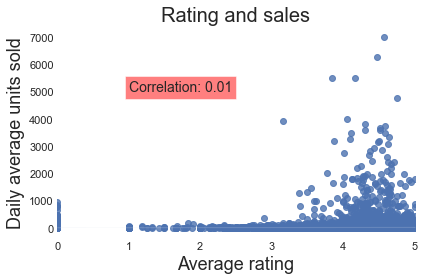

In [14]:
# average rating and daily units sold
sns.regplot(y='daily_average_units_sold',
            x='average_rating',
            data=sales)

# Correlation box
s = np.corrcoef(sales.daily_average_units_sold, sales.average_rating)[0,1]
s = f'Correlation: {np.round(s, 2)}'
plt.text(y=5000,
         x=1,
         s=s,
         fontsize=14,
         bbox=dict(facecolor='red', alpha=0.5))

# plot parameter
plt.title('Rating and sales')
plt.ylabel('Daily average units sold')
plt.xlabel('Average rating')
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig(f'{image_path}\\average_ratings_and_sales.png')

## 2.2 - Number of reviews

Number of reviews has a biggest effect on sales so far. With a correlation coefficient
of 0.33, this might be the most important factor in popular book. However, this comes
with a caveat: number of reviews makes book popular or popular books have more
reviews. While this is a hard question to answer with data alone, there are ways
to [get more reviews](https://www.writersdigest.com/marketing-self-promotion/how-to-get-reviews-for-self-published-books)
and thus generate more popularity. Thus, it is possible to use number of reviews
as a metric for creating a popular book.

d:\pycharmprojects\springboard\venv\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


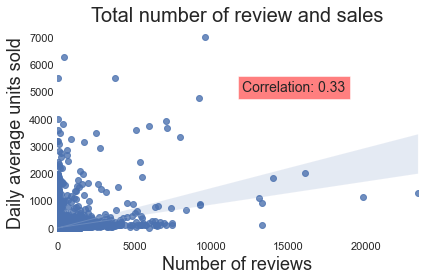

In [15]:
# number of review and sales
sns.regplot(sales.total_reviews, sales.daily_average_units_sold)

# Correlation box
s = np.corrcoef(sales.daily_average_units_sold, sales.total_reviews)[0,1]
s = f'Correlation: {np.round(s, 2)}'
plt.text(x=12000,
         y=5000,
         s=s,
         fontsize=14,
         bbox=dict(facecolor='red', alpha=0.5))

# plot parameters
plt.title('Total number of review and sales')
plt.xlabel('Number of reviews')
plt.ylabel('Daily average units sold')
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig(f'{image_path}\\number_of_reviews_and_sales.png')

It is also worth noting that similar to sales, number of reviews does not correlate
with rating.

d:\pycharmprojects\springboard\venv\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


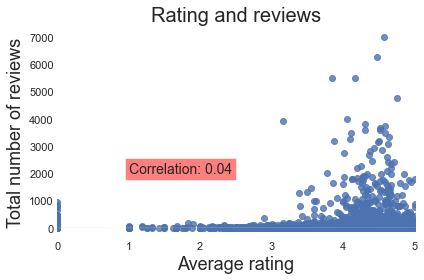

In [16]:
# average rating and daily units sold
sns.regplot(y='daily_average_units_sold',
            x='average_rating',
            data=sales)

# Correlation box
s = np.corrcoef(sales.total_reviews, sales.average_rating)[0,1]
s = f'Correlation: {np.round(s, 2)}'
plt.text(y=2000,
         x=1,
         s=s,
         fontsize=14,
         bbox=dict(facecolor='red', alpha=0.5))

# plot parameter
plt.title('Rating and reviews')
plt.ylabel('Total number of reviews')
plt.xlabel('Average rating')
plt.tight_layout()
sns.despine(left=True, bottom=True)

# 3. Publishers

There are over 300 publishers in the dataset with smaller ones grouped together
as indie, medium, single authors...Publisher type is a good indicator of a
popular book. big five publishers titles are more popular and sales more.

The big five publishers are: Penguin Random House, HarperCollins, Macmillan,
Hachette Book Group, and Simon & Schuster. Some insights based on the data:
1. big five has less titles count but a much better sale figures
2. big five has a higher median starting price

However, it is worth noting that big five publishers do not accept manuscripts
from authors without literary agents. It is also interesting to see that these
publishers are very well with the digital revolution.

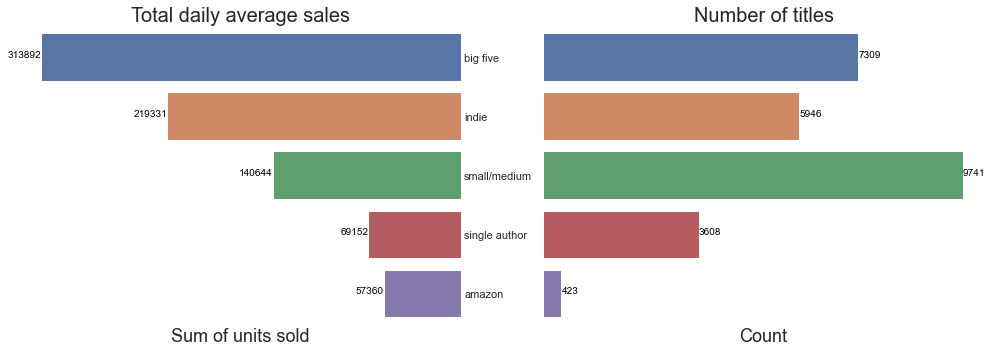

In [17]:
# set up plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# create total daily sales data by publishers
df = sales.groupby('publisher_type')['daily_average_units_sold'].sum().reset_index()
df = df.sort_values('daily_average_units_sold', ascending=False)

# Left plot with book count by publisher type
sns.barplot(y='publisher_type',
            x='daily_average_units_sold',
            data=df,
            ax=ax1)

# Left plot parameters
ax1.invert_xaxis()
ax1.set_title('Total daily average sales')
ax1.set_xlabel('Sum of units sold')
ax1.yaxis.tick_right()
ax1.set_ylabel('')
ax1.set_xticks([])
sns.despine(ax=ax1, left=True, bottom=True)

# Adding text to left plot
df.index = np.arange(0,5)
for index, row in df.iterrows():
    ax1.text(row.daily_average_units_sold,
             row.name,
             row.daily_average_units_sold,
             color='black',
             ha='right')

# create total book count data by publishers
df2 = sales.groupby('publisher_type')['daily_average_units_sold'].count().reset_index()

# sorting the right order for nicer plot
publisher_list = list(df.publisher_type)
mapping = {publisher: i for i, publisher in enumerate(publisher_list)}
key = df2['publisher_type'].map(mapping)
df2 = df2.iloc[key.argsort()]

# Right plot with book daily sales by publisher type
sns.barplot(y='publisher_type',
            x='daily_average_units_sold',
            data=df2,
            ax=ax2)

# right plot parameters
ax2.set_title('Number of titles')
ax2.set_ylabel('')
ax2.set_xlabel('Count')
ax2.set_xticks([])
sns.despine(ax=ax2, left=True, bottom=True)

# adding text and remove axis
df2.index = np.arange(0,5)
for index, row in df2.iterrows():
    ax2.text(row.daily_average_units_sold,
             row.name,
             row.daily_average_units_sold,
             color='black',
             ha='left')

# Plot parameteres
fig.tight_layout()
fig.savefig(f'{image_path}\\publisher_book_count_vs_sale.png')

# 4. Genre

Some observations from examining the distribution of ebook titles and daily sales
broken down by genre:
* non-fiction and genre fiction dominates the market in both number of titles and
sales. Only these two have multiple titles that sales on average 1000+ copy daily.
* Trying to be popular in niche genre such as children (Dr.Seuss) and comics (Stan Lee)
 is much harder compared to other genres.

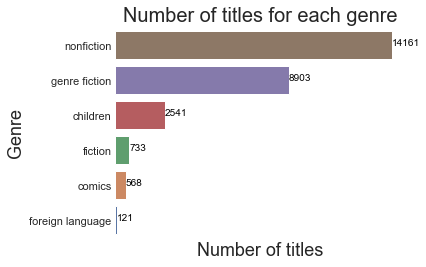

In [18]:
# Group books by genre and count number of book in each genre
df = sales.groupby('genre')['daily_average_units_sold'].count().reset_index()
df = df.sort_values('daily_average_units_sold', ascending=False)

# plot
g = sns.barplot(x='daily_average_units_sold',
                y='genre',
                hue='daily_average_units_sold',
                dodge=False,
                data=df)

# insert numbers beside the bars
df.index = np.arange(0,6)
for index, row in df.iterrows():
    g.text(row.daily_average_units_sold, row.name, row.daily_average_units_sold, color='black', ha='left')

# plot parameters
sns.despine(left=True, bottom=True)
plt.xlabel('Number of titles')
plt.ylabel('Genre')
plt.title('Number of titles for each genre')
plt.tight_layout()
plt.gca().get_legend().remove()
plt.xticks([])

# save figures
plt.savefig(f'{image_path}\\number_titles_genre.png')

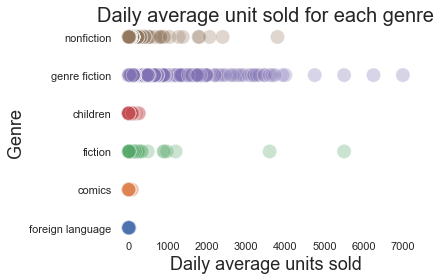

In [19]:
# copy df as sales
df = sales

# Sorting the right order
genre_list = ['foreign language', 'comics', 'fiction', 'children', 'genre fiction', 'nonfiction']
mapping = {genre: i for i, genre in enumerate(genre_list)}
key = df['genre'].map(mapping)

# sort order of genre based on the list
df = df.iloc[key.argsort()]

# Daily unit sold of books broken down by genre
sns.scatterplot(y='genre', x='daily_average_units_sold',
                hue='genre',
                s=200,
                alpha=0.3,
                data=df)

# Adjusting plot parameters
sns.despine(left=True, bottom=True)
plt.xlabel('Daily average units sold')
plt.ylabel('Genre')
plt.title('Daily average unit sold for each genre')
plt.tight_layout()
plt.gca().get_legend().remove()

plt.savefig(f'{image_path}\\genre_unit_sold.png')